# 파이토치 입문 - mnist 데이터셋을 이용한 글자분류 모델 제작

In [1]:
import torch
import torch.nn as nn # 딥러닝 모델 만들 때 필요한 것들 다 들어있음(레이어, 모델 등)
import torch.nn.functional as F # ReLU, pooling 등 자주 사용되는 함수들이 들어있다. 파이토치는 텐서플로우와 달리 얘들을 레이어로 추가하지 않는듯 하다. 
import torch.optim as optim # sgd 등이 들어있다
from torchvision import datasets, transforms # 파이토치는 딥러닝 모델 학습시킬 때 자주 사용되는 데이터셋과 데이터를 모델이 사용할 수 있게 변환해주는 함수를 지원해준다. 

from matplotlib import pyplot as plt 
%matplotlib inline 

# matplotlib inline : notebook을 실행한 브라우저에서 바로 그림을 볼 수 있게 해주는 것

## 사용할 장비 선택

In [2]:
is_cuda = torch.cuda.is_available() # GPU사용 가능한가?
device = torch.device('cuda' if is_cuda else 'cpu') # GPU 사용 가능하면 GPU쓰고 아니면 CPU사용

print('Current cuda device is', device)

Current cuda device is cpu


In [3]:
batch_size = 50
epoch_num = 15
learning_rate = 0.0001

## 데이터셋 생성

In [4]:
train_data = datasets.MNIST(root = '/Users/minguinho/Documents/AI_Datasets/data', train = True, download = False, # download: root에 저장된 위치에 데이터를 다운받는가? True면 NMIST의 전체 데이터셋이 다운됨
                            transform = transforms.ToTensor())
test_data  = datasets.MNIST(root = '/Users/minguinho/Documents/AI_Datasets/data', train = False, # train_set에서 NMIST를 다운받는다고 말했기 때문에(혹은 앞서 미리 다운받아놨기 때문에) 여기서는 False임
                            transform = transforms.ToTensor())

print('number of training data: ', len(train_data))
print('number of test data: '    , len(test_data) )


number of training data:  60000
number of test data:  10000


/Users/minguinho/opt/anaconda3/envs/python_pt/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## 데이터 확인

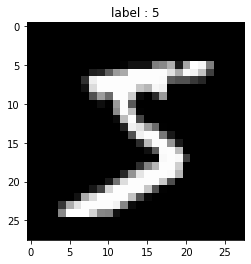

In [5]:
image, label = train_data[0] # (이미지, 라벨) 단위로 데이터셋이 구성된듯 하다

plt.imshow(image.squeeze().numpy(), cmap = 'gray') # squeeze : 크기가 1인 차원을 없애줌. 이 경우 [1, 28, 28] -> [28, 28]이 된다.
plt.title('label : %s' % label)
plt.show()

## 미니 배치 구성하기

In [6]:
# 데이터셋을 배치 단위로 분류한 뒤 셔플한다.
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)

first_batch = train_loader.__iter__().__next__() # 미니배치의 첫 번째 요소. 이미지 미니배치가 [0], 라벨 미니배치가 [1]이다.
print('{:15s} | {:<25s} | {}'.format('name', 'type', 'size'))
print('{:15s} | {:<25s} | {}'.format('Num of Batch', '', len(train_loader)))
print('{:15s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)), len(first_batch)))
# 배치당 이미지가 50개. 왜냐하면 mini_batch = 50으로 했기 때문
print('{:15s} | {:<25s} | {}'.format('first_batch[0]', str(type(first_batch[0])), first_batch[0].shape)) # 이미지 미니배치
print('{:15s} | {:<25s} | {}'.format('first_batch[1]', str(type(first_batch[1])), first_batch[1].shape)) # 라벨 미니배치

name            | type                      | size
Num of Batch    |                           | 1200
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 1, 28, 28])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([50])


In [7]:
class CNN(nn.Module):
    def __init__(self) :
        super(CNN, self).__init__()
        # CNN은 (입력 Tensor의 채널 크기, 출력 Tensor의 채널 크기(==Kernel 개수), Kernel 크기, stride) 형식의 입력값을 받는다.
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        # FCN은 (입력으로 받는 데이터 수, 뉴런 숫자) 형식의 입력값을 받는다.
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10) 

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x) # torch.nn.functional에서 relu, pooling을 불러옴
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim = 1) # softmax대신 이걸 쓰면 연산 속도가 더 높아진다고 한다
        return output

## Optimizer, loss 정의

In [8]:
model = CNN().to(device) # device에서 돌아가는 CNN 클래스의 객체를 선언
optimizer = optim.Adam(model.parameters(), lr = learning_rate) # learning rate에 따라 model의 가중치(parameters)들을 학습시킴
criterion = nn.CrossEntropyLoss() # 크로스 엔트로피를 loss로 지정

In [9]:
print(model) # 모델에 있는 layer의 정보를 출력. 등록 순서대로 출력되는듯? element의 이름을 알고 있다는게 신기하다. 

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## Model 학습

In [10]:
model.train() # 학습 모드로 변경. 학습모드는 연산할 때 dropout, BN등 학습할 때만 사용하는 함수들이 정방향 연산 과정에 사용된다
i = 0
for epoch in range(epoch_num) :
    for data, target in train_loader : # 입력 데이터, 라벨 데이터 하나씩 꺼내서
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad() # 그라데이션을 0으로 초기화
        output = model(data) # 예측값 구함
        loss = criterion(output, target) # loss를 구함
        loss.backward() # optimizer에 있는 grad를 구함. 신기하게도 grad가 optimizer에 클래스 내부에 element 형식으로 저장되어 있는듯 하다. 함부로 외부에서 접근하지 못하게 잘 짜놨다고 생각.
        optimizer.step() # 가중치(parameter)들을 업데이트 
        
        # 훈련 잘되나 확인하는 코드
        if i % 1000 == 0 :
            print('Train Step : {}\tLoss: {:.3f}'.format(i, loss.item()))
        i += 1

/Users/minguinho/opt/anaconda3/envs/python_pt/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Step : 0	Loss: 2.303
Train Step : 1000	Loss: 0.256
Train Step : 2000	Loss: 0.175
Train Step : 3000	Loss: 0.072
Train Step : 4000	Loss: 0.109
Train Step : 5000	Loss: 0.093
Train Step : 6000	Loss: 0.035
Train Step : 7000	Loss: 0.019
Train Step : 8000	Loss: 0.167
Train Step : 9000	Loss: 0.092
Train Step : 10000	Loss: 0.009
Train Step : 11000	Loss: 0.049
Train Step : 12000	Loss: 0.027
Train Step : 13000	Loss: 0.063
Train Step : 14000	Loss: 0.040
Train Step : 15000	Loss: 0.051
Train Step : 16000	Loss: 0.008
Train Step : 17000	Loss: 0.006
